In [1]:
from google.cloud import bigquery

#client_bq = bigquery.Client.from_service_account_json("./credentials.json", project='charged-dialect-824')

In [2]:
def load_bq_data(_sql):
    _df = client_bq.query(_sql).to_dataframe()
    return _df


sql = """
SELECT *
FROM RicardoInterview.product_detection_training_data
"""

"""df_load = load_bq_data(sql)
len(df_load)
df_load.head()"""

'df_load = load_bq_data(sql)\nlen(df_load)\ndf_load.head()'

In [3]:
#df_load.shape

# Brief look at the sample dataset

In [4]:
import numpy as np
import pandas as pd

In [5]:
raw=pd.read_csv("ricardo_data.csv", sep='|', index_col=0)
#raw=df_load

In [6]:
from collections import defaultdict

In [7]:
raw.head()

,articleId,title,subtitle,productType
0,-24471100344624315,Metal Hurlant,NaN,magazine
1,-4941423510709663049,Mikrophone,NaN,sound_card
2,6882901079846443092,Sound Blaster Audigy CREATIVE,Soundkarte für PC,sound_card
3,-309151326745158426,"Umlenkrolle Forst, extra leicht",100 kn / 10 Tonnen,winch
4,-3342786788349504714,MATSCHFACH MORITZ SPEZIAL,*GRATIS LIEFERUNG*,sandpit


In [8]:
print("\nAre there even any duplicates in the current state of the frame?\n")
print(raw.duplicated(keep=False).any())
if raw.duplicated(keep=False).any():
    raw.drop_duplicates(inplace=True)
    print("\nHow about now?\n")
    print(raw.duplicated(keep=False).any())


Are there even any duplicates in the current state of the frame?

True

How about now?

False


In [9]:
y=np.array(raw.productType)
classes=np.unique(y)
print("{} labeled samples for {} (!) target classes".format(len(y), len(classes)))

37073 labeled samples for 383 (!) target classes


A histogram of the frequencies of each product type in the sample set allows us to quickly confirm:
1. whether there are imbalances in the representation of target classes: Rather not, as all classes are represented by 50-99 samples, i.e. not even a single order of magnitude apart - this is quite a balanced set for a multiclass classifier.
2. whether there are serious outliers or even misspells etc in the taxonomy: no, the Product type column is clean

AxesSubplot(0.125,0.125;0.775x0.755)


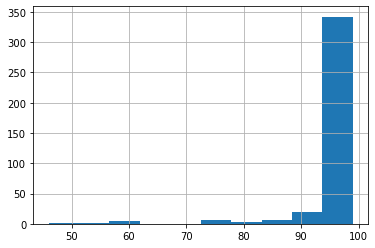

In [10]:
print(raw.productType.value_counts().hist()) # all classes represented n times, where 48<n<99

In [11]:
#Indeed:
raw.productType.value_counts().sort_values()[:3], raw.productType.value_counts().sort_values()[-3:]

(marble        46
 dump_truck    52
 holster       59
 Name: productType, dtype: int64,
 mirror_cabinet    99
 lamp              99
 car               99
 Name: productType, dtype: int64)

**Some early thoughts on the goal of this exercise:**
1. As the dataset is so balanced, even plain accuracy of the resulting model is a reliable metric for choosing a good variant.
2. Given the nature of the product *categorization task*, we do not really have a preference for minimizing Type I or Type II errors (in other words, we don't prioritize precision or recall when evaluating the classifier). A well-calibrated model with the highest possible generaization accuracy is the goal.

I will be evaluating alternatives using the **mean F1 score** (a harmonic mean of precision and recall), as the general best practice for scoring performance of multi-class classifiers, but the terms "f1 score" and "accuracy" can be used interchangeably, as the actual values will not differ much.

# Initial transformation to a BoF

Examining **title & subtitle as a single feature string** (after addressing empty subtitles): the rough(!) assumption is that the subtitles are not strictly inferior in informativeness for the target class to the main titles, as Ricardo users are not prompted so when entering. This hypothesis is worth examining, but not now.

In [12]:
raw = raw.replace(np.nan,'', regex=True)
raw["descr"]=raw.title+" "+raw.subtitle

In [13]:
all_of_it = raw.descr.str.cat(sep=' ')
print("The entire training corpus combined consists of", len(all_of_it), 'total characters in', len(all_of_it.split(" ")), 'total words')

The entire training corpus combined consists of 1647713 total characters in 252497 total words


**Basic Bag-of-words vectorization of the assembled title strings and subsequent further transformation of the vocabulary:**

In [14]:
import re
import spacy  # for lemmatization
import nltk   # for word stemming
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import bof_utils
lexicon = spacy.load("de_core_news_sm")
# lexicon = spacy.load("de")
bof_utils.nlp=lexicon

nltk.download('stopwords')
nltk.download('punkt')
nltk_stopwords_de = nltk.corpus.stopwords.words('german')
spacy_stopwords_de = spacy.lang.de.stop_words.STOP_WORDS

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [15]:
print(bof_utils.lemmatizer("jawohl, dieses Auto gehört mir, warum nicht, mein Mann, haben Sie auch ein gleiches?"))

['jawohl', ',', 'dies', 'Auto', 'hören', 'sich', ',', 'warum', 'nicht', ',', 'meinen', 'Mann', ',', 'haben', 'ich', 'auch', 'einen', 'gleich', '?']


In [16]:
print(bof_utils.de_blob_lemmatizer("jawohl, dieses Auto gehört mir, warum nicht, mein Mann, haben Sie auch ein gleiches"))

['jawohl', 'dies', 'Auto', 'gehören', 'mir', 'warum', 'nicht', 'mein', 'Mann', 'haben', 'Sie', 'auch', 'ein', 'gleiches']


In [17]:
_, bag= bof_utils.BoF(data=raw.descr)

Vocabulary size: 43977, training set size: 37073 samples * 43977 features
# of tokens automatically excluded from the vocabulary: 0


In [18]:
vocab = bag.get_feature_names()
corpus_vocab_count_dict={w:c for (w,c) in zip(vocab, bag.transform([all_of_it]).toarray()[0])}
sorted_corpus_count=sorted(corpus_vocab_count_dict.items(), key=lambda x: x[1])

In [19]:
sorted_corpus_count[-8:] # potentially uninformative, too frequent tokens (mostly German stopwords) at the top of the vocabulary pile

[('in', 959),
 ('gr', 1007),
 ('von', 1029),
 ('cm', 1196),
 ('und', 1391),
 ('neu', 1399),
 ('für', 2054),
 ('mit', 3604)]

In [20]:
sorted_corpus_count[:8] # potentially uninformative, too infrequent tokens at the bottom of the vocabulary pile

[('0018m2', 1),
 ('002', 1),
 ('003160', 1),
 ('0041', 1),
 ('0057', 1),
 ('00687', 1),
 ('006r01264', 1),
 ('008r13021', 1)]

In [21]:
variants=defaultdict(lambda: defaultdict(dict))
variants["default_vectorizer"]["vectorizers"]=bag

**Slightly more sophisticated corpus representation - dropping German stopwords:**

**ToDo**: Would be intriguing to build a language recognition pipeline based on this:
https://data-science-blog.com/blog/2018/11/12/language-detecting-with-sklearn-by-determining-letter-frequencies/
to treat titles written in French, English, German & Italian accordingly regarding stopwords/lemmatization.

In [22]:
stopwords=spacy_stopwords_de

_,variants["stopwords"]["vectorizers"]= bof_utils.BoF(data=raw.descr, stop_words=stopwords)

Vocabulary size: 43683, training set size: 37073 samples * 43683 features
# of tokens automatically excluded from the vocabulary: 0
# of stopwords that were effectively excluded : 543


**Rescaling the data with tf-idf:**

In [23]:
_, variants["w_tfidf"]["vectorizers"]= bof_utils.BoF(data=raw.descr, tfidf= True, stop_words=stopwords)

Vocabulary size: 43683, training set size: 37073 samples * 43683 features
# of tokens automatically excluded from the vocabulary: 0
# of stopwords that were effectively excluded : 543


**and force-excluding too frequent/infrequent terms from the vocabulary:**

In [24]:
_, variants["w_tfidf_min2_max100"]["vectorizers"]= bof_utils.BoF(data=raw.descr, tfidf= True,  min_df=2, max_df=100, stop_words=stopwords)

Vocabulary size: 16249, training set size: 37073 samples * 16249 features
# of tokens automatically excluded from the vocabulary: 27434
# of stopwords that were effectively excluded : 543


**...and enriching the feature set with some n-grams:**

In [25]:
variant="w_tfidf_ngram_3"

_, variants["w_tfidf_ngram_3"]["vectorizers"]= bof_utils.BoF(data=raw.descr, tfidf= True, min_df=2, ngram_range=(1,3), stop_words=stopwords)

Vocabulary size: 38450, training set size: 37073 samples * 38450 features
# of tokens automatically excluded from the vocabulary: 229193
# of stopwords that were effectively excluded : 543


**Last, trying lemmatization on the vocabulary**

In [26]:
for custom_tokenizer in [bof_utils.lemmatizer]:
    variant=custom_tokenizer.__name__+"_w_tfidf"
    _,variants[variant]["vectorizers"]= bof_utils.BoF(data=raw.descr,custom_tokenizer=custom_tokenizer, 
                          tfidf= True, min_df=2, stop_words=custom_tokenizer(", ".join(stopwords)))

/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"
/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['einigen', 'gleich', 'heiß', 'lieben', 'vergehen', 'wahr'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Vocabulary size: 16237, training set size: 37073 samples * 16237 features
# of tokens automatically excluded from the vocabulary: 31703
# of stopwords that were effectively excluded : 332


# Trying some (basic) Classifiers on these BoF representations:

 
 
**Observe the sparse nature of the bag-of-words data representation, which pretty much dictates the families of models applicable:**

In [27]:
X=variants["w_tfidf_min2_max100"]["vectorizers"].transform(raw.descr)
print(repr(X))

<37073x16249 sparse matrix of type '<class 'numpy.float64'>'
	with 123910 stored elements in Compressed Sparse Row format>


***Accuracy of random guessing:*** 

In [28]:
print("\n{:.2f} % ".format(100/len(classes)))


0.26 % 


 
 
... I 'd better beat this... :P
 
 

In [29]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.metrics import classification_report, f1_score

In [30]:
import nested_x_val
score_metric="f1_macro"

models=[MultinomialNB(alpha=.1) , SGDClassifier(random_state=101, loss="modified_huber")] # LogisticRegression(C=1., warm_start=True, class_weight='balanced'),
for variant in variants.keys():
    print("\nWith data from {}\n(vocabulary size: {}):".format(variant,len(variants[variant]["vectorizers"].get_feature_names())))
    _=nested_x_val.model_mvp(models,
                            variants[variant]["vectorizers"].transform(raw.descr),y, 
                            n_splits=3, n_jobs=1, score_metric=score_metric, random_state=101)


With data from default_vectorizer
(vocabulary size: 43977):
                                          train vs. test
f1_macro of default        MultinomialNB:  0.98     0.66
                                          train vs. test
f1_macro of default        SGDClassifier:  0.99     0.69

With data from stopwords
(vocabulary size: 43683):
                                          train vs. test
f1_macro of default        MultinomialNB:  0.98     0.67
                                          train vs. test
f1_macro of default        SGDClassifier:  0.99     0.70

With data from w_tfidf
(vocabulary size: 43683):
                                          train vs. test
f1_macro of default        MultinomialNB:  0.99     0.71
                                          train vs. test
f1_macro of default        SGDClassifier:  0.99     0.74

With data from w_tfidf_min2_max100
(vocabulary size: 16249):
                                          train vs. test
f1_macro of default        Multino

<img src="variance_acc_plot.png" alt="drawing" width="500"/>

**Some further conclusions from the prototyping:**
1. ... appears overfitting, at this point - mode training data will smoothen the BoF-tf-idf vector and increase accuracy
2. the **w_tfidf_min2_max100** settings for the BoF vectorization seem the best early choice: competitive accuracy but a severely downsized vocabulary size (-60% of the rest)


# Hyperparameter tuning of estimators on chosen representation

**i.  Choosing between the SVC and the NB**
 
**ii. Simultaneously applying a basic (cross-validated) grid search for optimal settings on their main regularization hyperparameters**

In [31]:
NB_alpha_range=[0.01,0.1,0.5,1.]
SVM_alpha_range=[0.00001,0.0001,0.001,0.01]
max_df_range=[50,100]
min_df_range=[2, 3]

**For the sake of validation of our choice of Bag-of-words specifics, we will actually run the hyper-tuning grid search on the entire pipeline of {data transformation --> classification}:**

In [32]:
e2e_pipe= Pipeline([('vectorizer',CountVectorizer()),('classifier', MultinomialNB())])
pipe_grid= [{"classifier":[MultinomialNB()], "vectorizer": [CountVectorizer(), TfidfVectorizer()],
            "classifier__alpha": NB_alpha_range, "vectorizer__max_df":max_df_range,"vectorizer__min_df":min_df_range, "vectorizer__stop_words":[None, stopwords]},
            {"classifier":[SGDClassifier(random_state=101, loss="modified_huber")], "vectorizer": [CountVectorizer(), TfidfVectorizer()],
            "classifier__alpha": SVM_alpha_range,"vectorizer__max_df":max_df_range,"vectorizer__min_df":min_df_range, "vectorizer__stop_words":[None, stopwords]}]

best_e2e = nested_x_val.nested_x_val_grid_search(e2e_pipe, raw.descr, y, pipe_grid, show_me_params= False, score_metric=score_metric)

Average f1_macro on the test set: 0.714
Average f1_macro score on the train set: 0.949


**For a more comprehensive review of the final predictor (end-to-end pipeline), we can review a classification report:**

In [33]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(raw.descr,y,stratify=y, test_size=0.2,random_state=102)
y_pred=best_e2e.fit(X_train,y_train).predict(X_test)
report=classification_report(y_test, y_pred, output_dict=True, target_names=best_e2e.classes_)
for metric in ['precision', 'recall', 'f1-score']: print("Trained model average {:>10} : {:>7.2f}".format(metric,report['macro avg'][metric]))

Trained model average  precision :    0.75
Trained model average     recall :    0.71
Trained model average   f1-score :    0.72


As expected for a very balanced training set, the model appears well calibrated, as precision & recall are aligned with the f1-score, and we can be confident of equivalent confidence when generalizing to new data.
**The model is ready to be deployed**.

In [34]:
# re-fitting the best model on the entire available labelled set:
final=best_e2e.fit(raw.descr,y)

In [35]:
print("Our prototype vectorizer:\n\n",final["vectorizer"])

Our prototype vectorizer:

 TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=100, max_features=None,
                min_df=2, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)


In [36]:
print("Our prototype classifier:\n\n",final["classifier"])

Our prototype classifier:

 SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='modified_huber',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=101, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)


# Ready for top-5 Product types predictions!

In [37]:
an_example_title="Blaster Moritz Mikrophone Batman Batman und Woot 10 100 Dimitrios Batman"

In [38]:
X_example=final["vectorizer"].transform([an_example_title])
vocab_in_example=list(X_example.nonzero()[1])   # remember, the sample is of sparse matrix type, NOT a dense array or list!
vocab=final["vectorizer"].get_feature_names()
print("The BoF representation of the to-be-classified example:")
print({vocab[i]:X_example[0, i] for i in vocab_in_example})

The BoF representation of the to-be-classified example:
{'moritz': 0.27391349074706517, 'mikrophone': 0.2940234097739994, 'blaster': 0.2459141001151946, 'batman': 0.8820702293219981}


In [39]:
# this all needs to be packaged as a single output function for the flask service:
import json
def predict_top5(doc, classifier):
        
    probas=classifier.predict_proba(doc)[0]
    top5=np.argsort(probas)[-5:]
        
    #requested JSON elements:
    title=doc
    top_5_results=[{"product_type": x, "score": "{:.4f}".format(y)} for (x,y) in zip(reversed(classes[top5]),reversed(probas[top5]))]
    product_type=classes[top5][-1]
    return json.dumps({"title": title, "top_5_results": top_5_results, "product_type": product_type}, indent=3)


In [40]:
print(predict_top5(["Blaster Moritz Mikrophone Batman Batman Woot 10 100 Dimitrios Batman"], final))

{
   "title": [
      "Blaster Moritz Mikrophone Batman Batman Woot 10 100 Dimitrios Batman"
   ],
   "top_5_results": [
      {
         "product_type": "bathrobe",
         "score": "0.3601"
      },
      {
         "product_type": "sound_card",
         "score": "0.2752"
      },
      {
         "product_type": "comic_book",
         "score": "0.0765"
      },
      {
         "product_type": "video_game_console",
         "score": "0.0697"
      },
      {
         "product_type": "sandpit",
         "score": "0.0594"
      }
   ],
   "product_type": "bathrobe"
}


In [41]:
import pickle
with open('trained.pkl', 'wb') as f: pickle.dump(final, f)  
    # the BoF transformer is shipped over to the Flask service also as a component of the pipelined predictor

**Ideas for further exploration and improvement:**
 
1. **The product taxonomy of Ricardo** is assumed robust - perhaps even some lemmaization on the target label column could identify possible merges. And then of course this ML exercise could, in the long run, even propose changes to the taxonomy, e.g. a discussion with Business Analytics
 
2. Text data is assumed to be in German throughout (not generally true on Ricardo.ch), a careful segmentation of samples via some **language identifier** would increase the performance of the lemmatizer and remove confusion to language-agnostic BoF algorithm where the same word means a different thing in 2 languages

3. **A hybrid system for prediction**: the ML model could be combined with, for example, a regex-based heuristic to improve accuracy - it doesn't all need to be AI!

4. Obviously, the performance of all model alternatives (especially linear varieties) will benefit tremendously and immediately from **a larger training dataset**

**-------- all of the above would help reduce the likely overfitting, which is unavoidable in early sparse text data classifiers ---------**

5. **Performance vs. portability tradeoff** of the REST API app: shipping the entire Bag-of-words vocabulary with the model as one pickle object increases Docker image size, but leaving it as an external file to be read in via drive-mapping lowers prediction speed. These are important considerations for live deployment

6. Moving the training/validation pipeline from Pandas/SKLearn to **Spark MLlib** on the Google Cloud would open up resource availability but also the option of batch processing, which means we can benefit from wider hyperparameter tuning Grids for our chosen models and explore all-new model options that just won't run locally

**Advanced** 

7. **Current research** seems to suggest that, a hierarchical classification scheme (where the taxonomy is not considered flat, like we have done here, but tree like, e.g. bicycle: {bicycle, saddle, helmet}...), coupled with Convolutional/Bi-directional NN's probably represents the state-of-the-art for classification based on title: 
https://arxiv.org/pdf/1903.04254v1.pdf
https://arxiv.org/pdf/1907.00420.pdf
https://arxiv.org/pdf/1812.05774v1.pdf
https://www.aclweb.org/anthology/E17-2105.pdf

8. Of course, a completely different direction would be **a multi-modal system** which makes use of all the information inserted by the user, not just title (incl. images) for next-level accuracy

9. So, how did you do it?
